# Introduction

This notebook uses a pre-trained Keras model to build a classifier to distinguish between pictures of cats and dogs.



# Import Dependencies

In [0]:
# This project uses tensorflow 2.0

!pip install -q tensorflow-gpu==2.0.0-beta1


     |████████████████████████████████| 348.9MB 76kB/s 
     |████████████████████████████████| 3.1MB 38.3MB/s 
     |████████████████████████████████| 501kB 52.9MB/s 


In [0]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model as KerasModel

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

tf.keras.backend.clear_session()

2.0.0-beta1


In [0]:
IMG_SIZE = 160 # All images will be resized to 160x160

# Acquire Dataset

In [0]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)


Show the first two training samples.

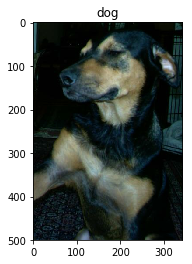

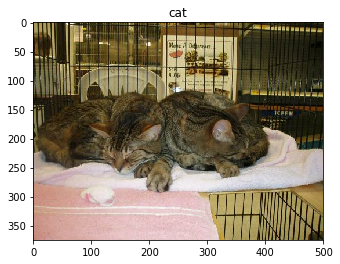

In [0]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

Next, let's prepare the datasets.

In [0]:


def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass



Let's interrogate the dimensions of our batch of data. In NHWC format, each batch consists of 32 images with dimensions 160x160 and 3 channels.


In [0]:
image_batch.shape

TensorShape([32, 160, 160, 3])

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Acquire Pre-Trained Model

Next, we'll download a model that was pre-trained on ImageNet. We'll use MobileNet since it will be much more lightweight than something like Resent-50 or Inception.

Also, we'll exclude the fully connected output layer from this model since we're going to re-train it for the cats vs dogs task.



In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

No we rebuild the classifier by adding a Softmax layer. Let's print out dimensions along the way so we understand the transformation.

First, the size of the final feature map is 5x5x1280 - height and width of 5 pixels, with 1280 kernels.

If we add a global average pooling step, we collapse the 5x5 dimensions.

This is a binary classification task, but we only need a single unit in the final dense layer. The output will be in the range of 0 to 1, and that distinguishes the class.


In [0]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5, 5, 1280)
(32, 1280)
(32, 1)


Here we add the global average layer and the dense layer on top of the feature map.

In [0]:
for layer in base_model.layers:
    layer.trainable = False




# Sanity Check Model Performance

In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


First, sanity check the model by demonstrating that it can overfit on a single mini batch.

In [0]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

EPOCHS = 5

history = model.fit(train_batches.take(1),
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
1/1 [==============================] - 14s 14s/step - loss: 0.0471 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 9s 9s/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 0.2509 - val_accuracy: 0.9099
Epoch 3/5
1/1 [==============================] - 9s 9s/step - loss: 0.0364 - accuracy: 1.0000 - val_loss: 0.2461 - val_accuracy: 0.9103
Epoch 4/5
1/1 [==============================] - 9s 9s/step - loss: 0.0320 - accuracy: 1.0000 - val_loss: 0.2423 - val_accuracy: 0.9116
Epoch 5/5
1/1 [==============================] - 9s 9s/step - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.2389 - val_accuracy: 0.9112


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


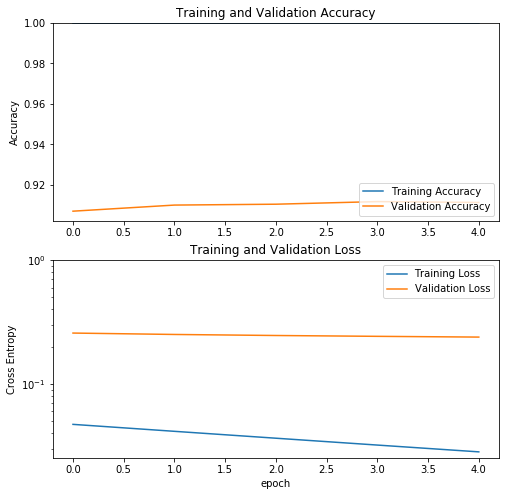

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.semilogy(loss, label='Training Loss')
plt.semilogy(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fetch a test image and evaluate model performance.

In [0]:
!wget https://upload.wikimedia.org/wikipedia/commons/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg
test_filename = 'Golden_Retriever_Carlos_(10581910556).jpg'

--2019-07-04 04:58:34--  https://upload.wikimedia.org/wikipedia/commons/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977940 (955K) [image/jpeg]
Saving to: ‘Golden_Retriever_Carlos_(10581910556).jpg.1’

Golden_Retriever_Ca 100%[===================>] 955.02K  --.-KB/s    in 0.1s    

2019-07-04 04:58:34 (9.64 MB/s) - ‘Golden_Retriever_Carlos_(10581910556).jpg.1’ saved [977940/977940]



Text(0.5, 1.0, 'cat')

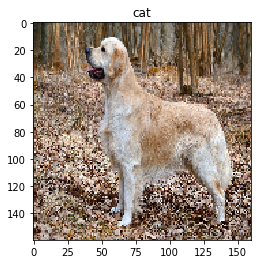

In [0]:
image = image_utils.load_img(test_filename, target_size=(IMG_SIZE, IMG_SIZE))

plt.figure()
plt.imshow(image)

image = preprocess_input(image_utils.img_to_array(image), mode='tf')
image = np.expand_dims(image, axis=0)
predicted_class_id = model.predict(image)
plt.title(get_label_name(tf.convert_to_tensor(predicted_class_id[0][0])))



The test image is misclassified, but considering the fact the the model was overfit on a single batch, this isn't surprising.

# Train on Full Dataset

In [0]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

EPOCHS = 5

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 77s 132ms/step - loss: 0.1308 - accuracy: 0.9468 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
582/582 [==============================] - 72s 124ms/step - loss: 0.1158 - accuracy: 0.9535 - val_loss: 0.1594 - val_accuracy: 0.9483
Epoch 3/5
582/582 [==============================] - 73s 126ms/step - loss: 0.1091 - accuracy: 0.9569 - val_loss: 0.1628 - val_accuracy: 0.9487
Epoch 4/5
582/582 [==============================] - 73s 126ms/step - loss: 0.1046 - accuracy: 0.9588 - val_loss: 0.1660 - val_accuracy: 0.9483
Epoch 5/5
582/582 [==============================] - 74s 127ms/step - loss: 0.1011 - accuracy: 0.9601 - val_loss: 0.1691 - val_accuracy: 0.9487


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


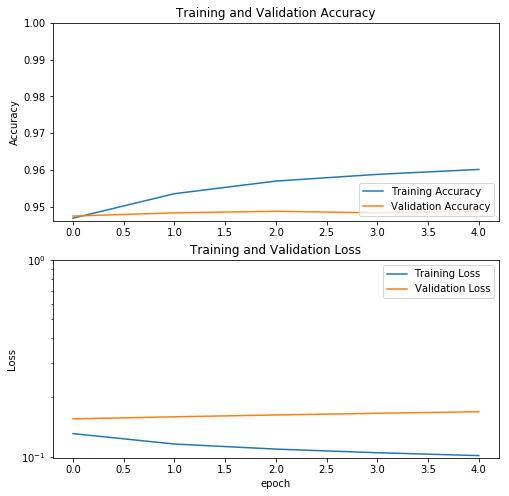

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.semilogy(loss, label='Training Loss')
plt.semilogy(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Text(0.5, 1.0, 'dog')

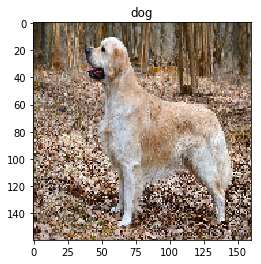

In [0]:
image = image_utils.load_img(test_filename, target_size=(IMG_SIZE, IMG_SIZE))

plt.figure()
plt.imshow(image)

image = preprocess_input(image_utils.img_to_array(image), mode='tf')
image = np.expand_dims(image, axis=0)
predicted_class_id = model.predict(image)
plt.title(get_label_name(int(np.round(predicted_class_id[0][0]))))

# Save Model

In [0]:
from google.colab import files

model_filename = 'cats-vs-dogs.hdf5'
model.save(model_filename)

files.download(model_filename) 

# Load Model and Predict


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
print(tf.__version__)
from tensorflow.keras.models import load_model

2.0.0-beta1


In [0]:
!ls "/content/drive/My Drive/projects/CatsVsDogs/cats-vs-dogs.hdf5"
model = tf.keras.models.load_model('/content/drive/My Drive/projects/CatsVsDogs/cats-vs-dogs.hdf5')

'/content/drive/My Drive/projects/CatsVsDogs/cats-vs-dogs.hdf5'


W0714 19:45:03.520972 140182091954048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


<class 'PIL.Image.Image'>


Text(0.5, 1.0, 'Dog')

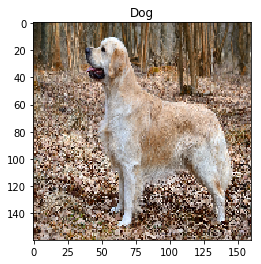

In [0]:
# This file should have been downloaded previously
#!wget https://upload.wikimedia.org/wikipedia/commons/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg
test_filename = 'Golden_Retriever_Carlos_(10581910556).jpg'

image = image_utils.load_img(test_filename, target_size=(IMG_SIZE, IMG_SIZE))
print(type(image))
plt.figure()
plt.imshow(image)


label_name_map = {0: 'Cat', 1: 'Dog'}


image = preprocess_input(image_utils.img_to_array(image), mode='tf')
image = np.expand_dims(image, axis=0)
predicted_class_id = model.predict(image)
plt.title(label_name_map[np.round(tf.convert_to_tensor(predicted_class_id[0][0]))])

In [0]:
input_shape = model.get_layer(index=0).input.shape[1:3]

assert input_shape[0] == 160